In [1]:
from env import *

## Read data and select learners

In [2]:
lcdb_df = pd.read_csv(os.path.expanduser('~/Documents/data/delegated_classification/lcdb/database/database-accuracy.csv'))
lcdb_df.head()

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508


In [3]:
build_cdp = lambda learner, openmlid, m: (
    lcdb_df
    .query('openmlid==@openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .pipe(
        dclf.BootstrappedBinomialMixtureContractDesignProblem.from_series,
        m=m,
        ensure_zero_cost_action=True,
    )
)

In [4]:
selected_openmlid = dclf.mnist_openmlid
learners = list(dclf.lcdb_learner_names)

<Axes: xlabel='size_train'>

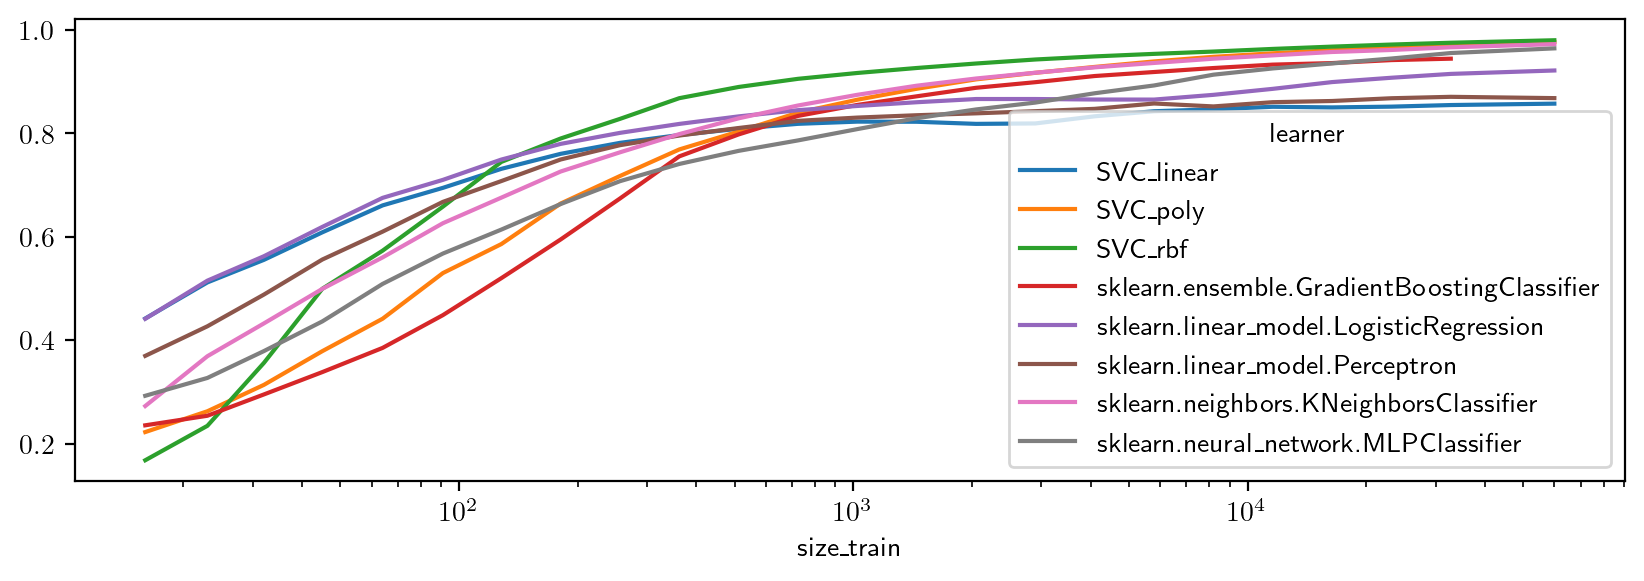

In [5]:
(
    lcdb_df
    .query('openmlid==@selected_openmlid and learner in @learners')
    .groupby(['size_train','learner'])
    ['score_test']
    .mean()
    .unstack()
    .plot.line(figsize=(10,3), logx=True)
)

## Compute grid

In [6]:
lp_results = []

contracts = {
    'lp': dclf.MinBudgetContract.design,
    'threshold': functools.partial(
        dclf.FullEnumerationContract.design,
        monotone=True,
    ),
    'all_or_nothing': functools.partial(
        dclf.FullEnumerationContract.design,
        monotone=False,
    ),
    'sba': functools.partial(
        dclf.MinBudgetSingleBindingActionContract.design,
        compare_to_all=False,
    ),
    'hybrid': dclf.MinBudgetHybridContract.design,
}

EPS = 1e-6

selected_m = param(10,'selected_m')

def is_mlrp(f_ij, eps=EPS):
    n = len(f_ij)
    q = f_ij[n-1]
    for i in range(1,n-1):
        p = f_ij[i]
        if not (np.diff(q/p)>=-eps).all():
            return False
    return True


for learner in tqdm(learners, position=0):
    cdp = build_cdp(learner, selected_openmlid, m=selected_m)
    for target,c in enumerate(
        tqdm(cdp.cost, position=1, leave=False),
    ):
        if cdp.cost[target]<=param(100,'min_cost'):
            continue
        if cdp.mean_acc[target] <= cdp.mean_acc[:target].max() + 1e-6:
            continue
        mlrp = is_mlrp(cdp.f_ij[:target+1])
        prev_mlrp = is_mlrp(cdp.f_ij[target-1:target+1])
        for contract_type, design_func in contracts.items():
            out = {
                'learner': learner,
                'learner_name': dclf.lcdb_learner_names[learner],
                'cdp': cdp,
                'target_action': target,
                'target_acc': cdp.mean_acc[target],
                'n': c,
                'is_mlrp': mlrp,
                'is_prev_mlrp': prev_mlrp,
                'contract_type': contract_type,
                'contract': None,
                'is_feasible': False,
            }

            try:
                contract = design_func(
                    design_problem=cdp,
                    target_action=target,
                )
                out['contract'] = contract
                if contract['t'][0]==None:
                    raise RuntimeError
                response = dclf.get_agent_response(cdp,contract['t'])
                if response.selected_action<target:
                    raise RuntimeError
                out['is_feasible'] = True
                out['t'] = contract['t']
                out['is_monotone'] = dclf.is_monotone(contract['t'])
                out['is_threshold'] = dclf.is_threshold(contract['t'])
                out['is_all_or_nothing'] = dclf.is_all_or_nothing(contract['t'])
                out['is_local'] = contract.get('solver')=='sba'
                out['B'] = contract['t'].max()
                out['wall_time'] = contract['wall_time']
            except (ZeroDivisionError, RuntimeError) as e:
                out['error'] = e

            lp_results.append(out)

lp_results_df = pd.DataFrame(lp_results)
lp_results_df.head()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

,learner,learner_name,cdp,target_action,target_acc,n,is_mlrp,is_prev_mlrp,contract_type,contract,is_feasible,t,is_monotone,is_threshold,is_all_or_nothing,is_local,B,wall_time,error
0,sklearn.neural_network.MLPClassifier,MLP,<dclf.common_types.BootstrappedBinomialMixture...,7,0.613696,128,True,True,lp,"{'primal_model': [None], 'primal_result': {'Pr...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408767330...",True,True,True,False,318.774088,0.144107,NaN
1,sklearn.neural_network.MLPClassifier,MLP,<dclf.common_types.BootstrappedBinomialMixture...,7,0.613696,128,True,True,threshold,"{'t': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408767330...",True,True,True,False,318.774088,0.000177,NaN
2,sklearn.neural_network.MLPClassifier,MLP,<dclf.common_types.BootstrappedBinomialMixture...,7,0.613696,128,True,True,all_or_nothing,"{'t': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408767330...",True,True,True,False,318.774088,0.011507,NaN
3,sklearn.neural_network.MLPClassifier,MLP,<dclf.common_types.BootstrappedBinomialMixture...,7,0.613696,128,True,True,sba,"{'t': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408767330...",True,True,True,False,318.774088,0.000183,NaN
4,sklearn.neural_network.MLPClassifier,MLP,<dclf.common_types.BootstrappedBinomialMixture...,7,0.613696,128,True,True,hybrid,"{'t': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408767330...",True,True,True,True,318.774088,0.000024,NaN


## Prevalence analysis table

### Excess cost

In [7]:
groupby_overall = lambda df: pd.concat([
    df.groupby(level=0).mean(),
    df.mean().rename('Overall').to_frame().transpose(),
])

In [8]:
ratio = lambda col1, col2, offset=0: (lambda df: df[col1]/df[col2]+offset)

new_cols = {
    f'ratio_{contract_type}': ratio(contract_type,'lp',-1)
    for contract_type in contracts
    if contract_type!='lp'
}
ratio_s = (
    lp_results_df
    .query('is_feasible')
    .pivot(
        index=['learner','n'],
        columns='contract_type',
        values='B',
    )
    # .dropna(subset='lp')
    .dropna(subset=set(contracts)-{'sba'})
    .assign(**new_cols)
    .iloc[:,-len(new_cols):]
    .pipe(groupby_overall)
)
(ratio_s*100).style.format('{:.2f}')

contract_type,ratio_threshold,ratio_all_or_nothing,ratio_sba,ratio_hybrid
SVC_linear,1.45,0.95,-0.00,-0.00
SVC_poly,0.24,0.24,-0.00,-0.00
SVC_rbf,0.04,0.04,-0.00,-0.00
sklearn.ensemble.GradientBoostingClassifier,0.71,0.71,-0.00,-0.00
sklearn.linear_model.LogisticRegression,-0.00,-0.00,-0.00,-0.00
sklearn.linear_model.Perceptron,0.00,0.00,-0.00,-0.00
sklearn.neighbors.KNeighborsClassifier,0.00,0.00,-0.00,-0.00
sklearn.neural_network.MLPClassifier,0.04,0.04,-0.00,-0.00
Overall,0.26,0.22,-0.00,-0.00


### Speedup factor
Calculate the mean wall time for each method, and compare to the LP method which uses a generic LP solver:

In [9]:

(
    lp_results_df
    .query('is_feasible')
    .pivot(
        index=['learner','n'],
        columns='contract_type',
        values='wall_time',
    )
    .dropna(subset='lp')
    .assign(speedup_factor=lambda df: df['lp']/df['sba'])
    .pipe(groupby_overall)
)

contract_type,all_or_nothing,hybrid,lp,sba,threshold,speedup_factor
SVC_linear,0.011298,0.019980,0.091272,0.000056,0.000149,2229.394396
SVC_poly,0.011320,0.005026,0.095783,0.000036,0.000146,2688.361493
SVC_rbf,0.011376,0.004815,0.091391,0.000039,0.000151,2342.071516
sklearn.ensemble.GradientBoostingClassifier,0.011284,0.019379,0.095754,0.000060,0.000149,2401.788882
sklearn.linear_model.LogisticRegression,0.011315,0.016265,0.092426,0.000057,0.000151,2216.933249
sklearn.linear_model.Perceptron,0.011315,0.023055,0.092096,0.000077,0.000150,2175.821666
sklearn.neighbors.KNeighborsClassifier,0.011817,0.000027,0.111550,0.000043,0.000150,2631.046647
sklearn.neural_network.MLPClassifier,0.011319,0.005045,0.100636,0.000044,0.000151,2700.851266
Overall,0.011389,0.011161,0.096640,0.000050,0.000149,2453.112359


### Proportion calculations

In [10]:
attrib_s = lambda attrib: (
    lp_results_df
    .query('is_feasible')
    .pivot(
        index=['learner','n'],
        columns='contract_type',
        values=attrib,
    )
    ['hybrid']
    .astype(float)
    .to_frame()
    .pipe(groupby_overall)
    # .groupby(level=0)
    # .mean()
    .iloc[:,0]
    .rename(f'pct_{attrib}')
)

attrib_s('is_monotone')


SVC_linear                                     0.857143
SVC_poly                                       1.000000
SVC_rbf                                        1.000000
sklearn.ensemble.GradientBoostingClassifier    1.000000
sklearn.linear_model.LogisticRegression        0.937500
sklearn.linear_model.Perceptron                0.937500
sklearn.neighbors.KNeighborsClassifier         1.000000
sklearn.neural_network.MLPClassifier           1.000000
Overall                                        0.970370
Name: pct_is_monotone, dtype: float64

In [11]:
col_names = {
    'pct_is_mlrp': '\\% MLRP',
    'pct_is_local': '\\% SBA',
    'pct_is_monotone': '\\% Monotone',
    'pct_is_all_or_nothing': '\\% All-or-nothing',
    'pct_is_threshold': '\\% Threshold',
    'ratio_all_or_nothing': 'Excess cost: All-or-nothing',
    'ratio_threshold': 'Excess cost: threshold',
}
format_pct = lambda x: f'{x*100:.3g}\\%'
format_rel = lambda x: f'{(0 if abs(x)<1e-5 else x)*100:.2f}\\%'
format_speedup = lambda x: f'{x:.0f}x'
formatters = {
    'pct_is_mlrp': format_pct,
    'pct_is_monotone': format_pct,
    'pct_is_threshold': format_pct,
    'pct_is_local': format_pct,
    'pct_is_all_or_nothing': format_pct,
    'ratio_threshold': format_rel,
    'ratio_all_or_nothing': format_rel,
}

out_df = (
    pd.concat(
        [
            ratio_s,
            attrib_s('is_mlrp'),
            attrib_s('is_monotone'),
            attrib_s('is_threshold'),
            attrib_s('is_all_or_nothing'),
            attrib_s('is_local'),
        ],
        axis=1,
    )
    .loc[learners+['Overall'],list(col_names)]
    .rename(
        col_names,
        axis=1,
    )
    .rename(
        dclf.lcdb_learner_names
    )
    .style
    .format(
        {col_names[col]: formatters[col] for col in col_names},
    )
)
out_df

,\% MLRP,\% SBA,\% Monotone,\% All-or-nothing,\% Threshold,Excess cost: All-or-nothing,Excess cost: threshold
MLP,100\%,94.4\%,100\%,94.4\%,94.4\%,0.04\%,0.04\%
GBDT,100\%,76.5\%,100\%,82.4\%,82.4\%,0.71\%,0.71\%
Logistic,93.8\%,81.2\%,93.8\%,93.8\%,93.8\%,0.00\%,0.00\%
Perceptron,68.8\%,75\%,93.8\%,93.8\%,93.8\%,0.00\%,0.00\%
Linear SVM,71.4\%,78.6\%,85.7\%,85.7\%,85.7\%,0.95\%,1.45\%
Poly SVM,100\%,94.4\%,100\%,94.4\%,94.4\%,0.24\%,0.24\%
RBF SVM,100\%,94.4\%,100\%,94.4\%,94.4\%,0.04\%,0.04\%
KNN,100\%,100\%,100\%,100\%,100\%,0.00\%,0.00\%
Overall,92.6\%,87.4\%,97\%,92.6\%,92.6\%,0.22\%,0.26\%


In [12]:
import re
print(re.sub('^(\\S.*?)(?=&)',lambda m: f'\\textbf{{{m.groups()[0].strip()}}} ',out_df.to_latex(hrules=True),flags=re.MULTILINE))

\begin{tabular}{lrrrrrrr}
\toprule
 & \% MLRP & \% SBA & \% Monotone & \% All-or-nothing & \% Threshold & Excess cost: All-or-nothing & Excess cost: threshold \\
\midrule
\textbf{MLP} & 100\% & 94.4\% & 100\% & 94.4\% & 94.4\% & 0.04\% & 0.04\% \\
\textbf{GBDT} & 100\% & 76.5\% & 100\% & 82.4\% & 82.4\% & 0.71\% & 0.71\% \\
\textbf{Logistic} & 93.8\% & 81.2\% & 93.8\% & 93.8\% & 93.8\% & 0.00\% & 0.00\% \\
\textbf{Perceptron} & 68.8\% & 75\% & 93.8\% & 93.8\% & 93.8\% & 0.00\% & 0.00\% \\
\textbf{Linear SVM} & 71.4\% & 78.6\% & 85.7\% & 85.7\% & 85.7\% & 0.95\% & 1.45\% \\
\textbf{Poly SVM} & 100\% & 94.4\% & 100\% & 94.4\% & 94.4\% & 0.24\% & 0.24\% \\
\textbf{RBF SVM} & 100\% & 94.4\% & 100\% & 94.4\% & 94.4\% & 0.04\% & 0.04\% \\
\textbf{KNN} & 100\% & 100\% & 100\% & 100\% & 100\% & 0.00\% & 0.00\% \\
\textbf{Overall} & 92.6\% & 87.4\% & 97\% & 92.6\% & 92.6\% & 0.22\% & 0.26\% \\
\bottomrule
\end{tabular}



## Concave-MLRP

In [13]:
j0 = lambda p,q: (q-p>=0).argmax()

  0%|          | 0/8 [00:00<?, ?it/s]

sklearn.neural_network.MLPClassifier 95711.9860573067 20
sklearn.ensemble.GradientBoostingClassifier 292382.271160904 N/A
sklearn.linear_model.LogisticRegression 113076.70473185 15
sklearn.linear_model.Perceptron 556478.058415423 N/A
SVC_linear 595575.771655752 N/A
SVC_poly 119884.702041504 20
SVC_rbf 149293.447741498 20
sklearn.neighbors.KNeighborsClassifier 112577.522490465 20


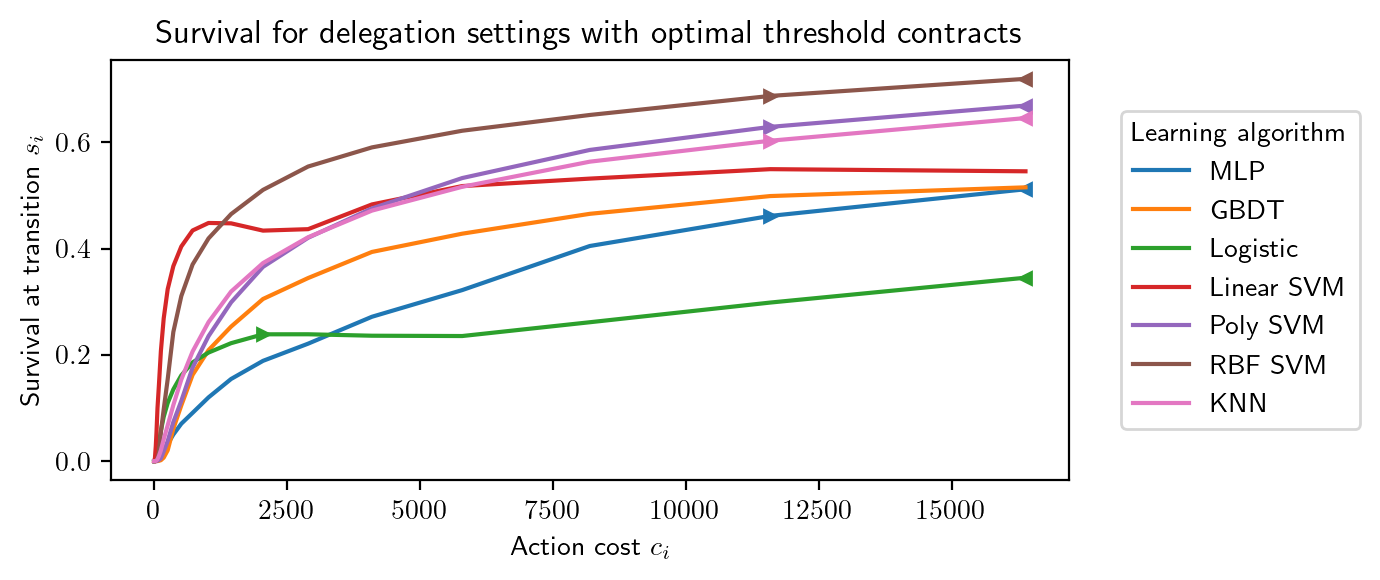

In [14]:
target = 21

fig,ax = plt.subplots(1,1,figsize=(7,3), tight_layout={'w_pad':2})

for learner in tqdm(learners):
    cdp = build_cdp(learner, selected_openmlid, m=selected_m)
    lp_contract = dclf.MinBudgetContract.design(cdp, target_action=target)
    try:
        local_contract = dclf.MinBudgetSingleBindingActionContract.design(cdp, target_action=target, compare_to_all=True)
    except RuntimeError:
        local_contract = None
    print(
        learner,
        lp_contract['t'].max(),
        local_contract['binding_action'] if local_contract is not None else 'N/A',
    )
    if not dclf.is_threshold(lp_contract['t']):
        continue
    l = ax.plot(
        cdp.cost[:target+1],
        cdp.sf_ij[:target+1,j0(*cdp.f_ij[-2:])-1],
        label=dclf.lcdb_learner_names[learner],
        # linestyle='--' if (local_contract is None or local_contract['binding_action']!=target-1) else '-',
    )
    if local_contract is not None:
        ax.plot(
            cdp.cost[local_contract['binding_action']],
            cdp.sf_ij[local_contract['binding_action'],j0(*cdp.f_ij[-2:])-1],
            '>',
            markersize=4,
            color=l[0].get_color(),
        )
        ax.plot(
            cdp.cost[target],
            cdp.sf_ij[target,j0(*cdp.f_ij[-2:])-1],
            '<',
            markersize=4,
            color=l[0].get_color(),
        )

ax.set(
    title=f'Survival for delegation settings with optimal threshold contracts',
    ylabel='Survival at transition $s_i$',
    xlabel='Action cost $c_i$',
)
ax.legend(
    bbox_to_anchor=(1.04, 0.5),
    loc='center left',
    # ncol=2,
    title='Learning algorithm',
)


In [15]:
plot_learning_curve = lambda learner, ax, target, **kwargs: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .apply(dclf.describe_series_of_samples)
    .iloc[:target]
    .pipe(
        dclf.df_plot_curve_with_band,
        mean='mean',
        lb='std_lb',
        ub='std_ub',
        ax=ax,
        label=learner,
        marker='.',
        markersize=3,
        **kwargs,
    )
)

0it [00:00, ?it/s]

sklearn.neural_network.MLPClassifier
B=112088.411047268
Binding action: 20
j^*=24
sklearn.ensemble.GradientBoostingClassifier
B=318209.381101408
Binding action: N/A
j^*=24
sklearn.linear_model.LogisticRegression
B=161347.410464142
Binding action: 15
j^*=23
sklearn.neighbors.KNeighborsClassifier
B=91252.0337984535
Binding action: 20
j^*=24


Text(0.02, 0.5, 'Learning algorithm')

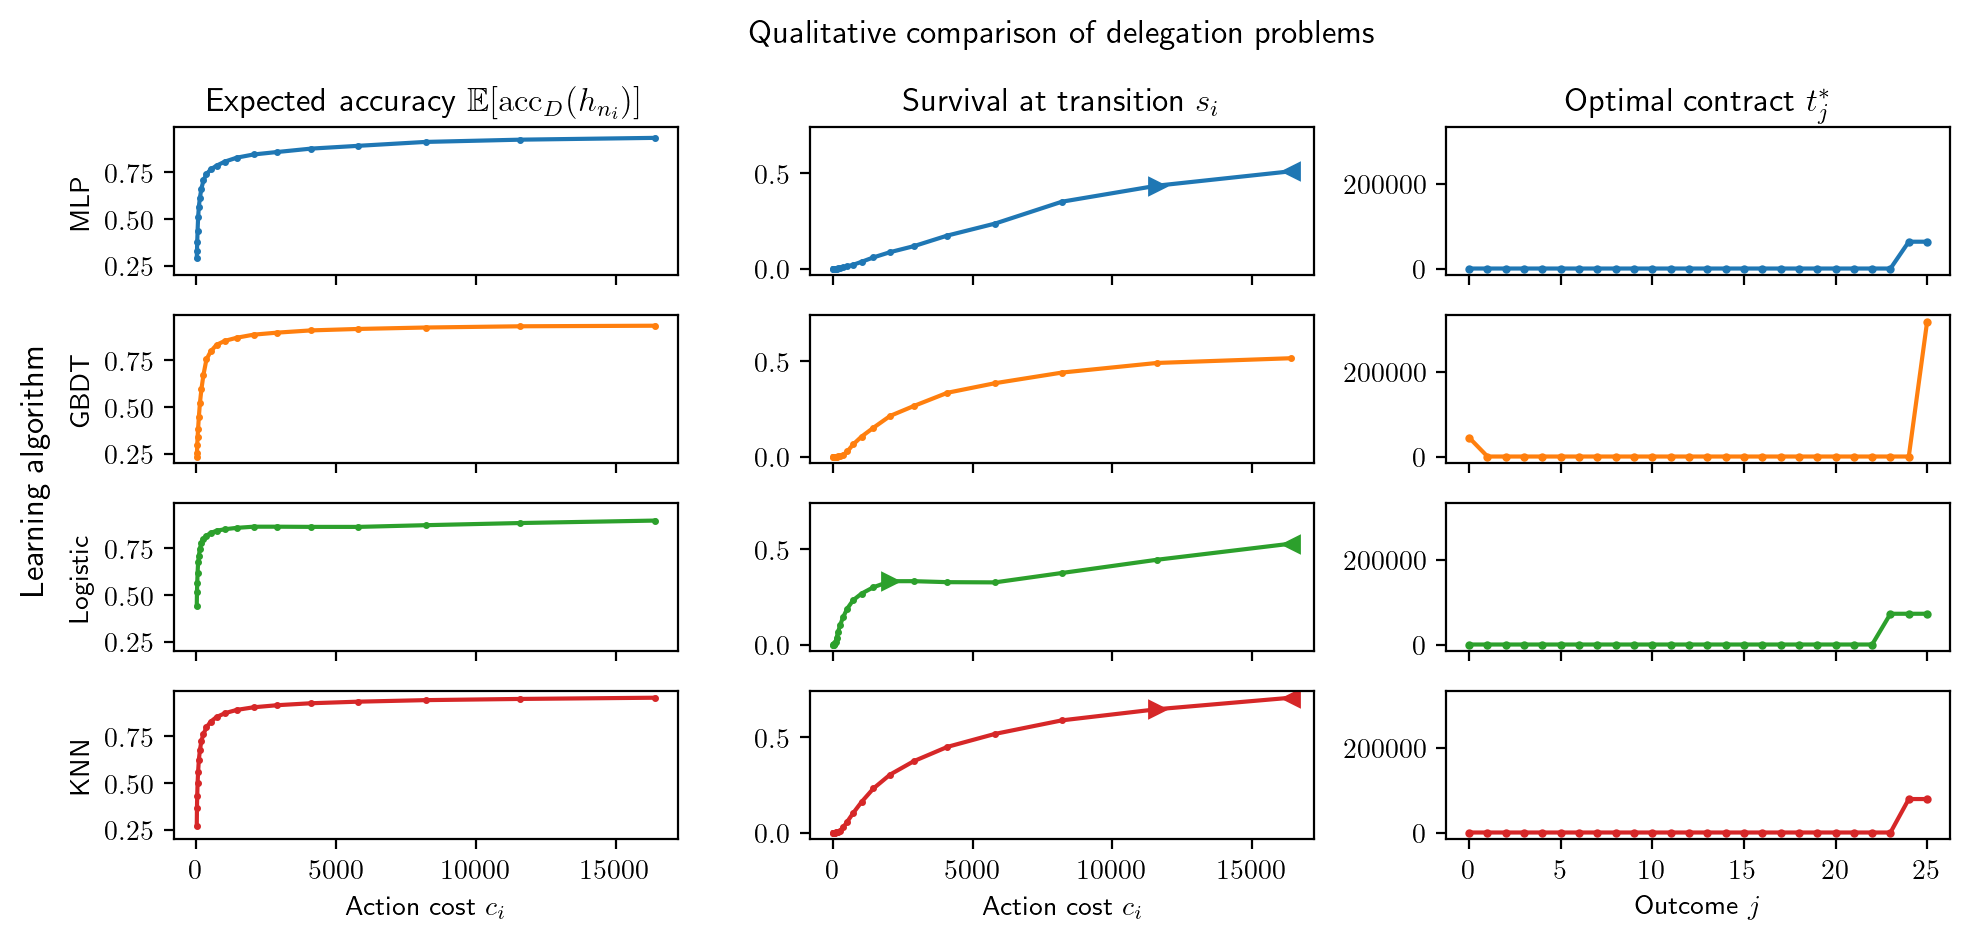

In [16]:
target = 21

learners_to_plot = [
    'sklearn.neural_network.MLPClassifier',
    'sklearn.ensemble.GradientBoostingClassifier',
    'sklearn.linear_model.LogisticRegression',
    'sklearn.neighbors.KNeighborsClassifier',
]


fig,axs = plt.subplots(
    len(learners_to_plot),
    3,
    figsize=(10,len(learners_to_plot)*1.2),
    sharex='col',
    sharey='col',
    layout='tight',
)

closest_ind = lambda arr, val: np.argmin(np.abs(np.array(arr)-val))

for i,learner in tqdm(enumerate(learners_to_plot)):
    cdp = build_cdp(learner, selected_openmlid, m=param(25,'qualitative_comparison_m'))
    lp_contract = dclf.MinBudgetContract.design(cdp, target_action=target)
    try:
        local_contract = dclf.MinBudgetSingleBindingActionContract.design(cdp, target_action=target, compare_to_all=True)
    except RuntimeError:
        local_contract = None
    if lp_contract['t'][0] is None:
        continue 
        
    print(learner)
    print(f'B={lp_contract["t"].max()}')
    print(
        'Binding action:',
        local_contract['binding_action'] if local_contract is not None else 'N/A',
    )
    
    c = list(matplotlib.colors.TABLEAU_COLORS)[i]
    axs_it = iter(axs[i])
    
    # Learning curve
    ax = next(axs_it)
    max_i = target+1
    ax.plot(cdp.cost[1:max_i], cdp.mean_acc[1:max_i],'.-',markersize=3,c=c)
    if i==0:
        ax.set(title='Expected accuracy $\\mathbb{E}[\\mathrm{acc}_D(h_{n_i})]$')
    if i==len(learners_to_plot)-1:
        ax.set(xlabel='Action cost $c_i$')
    
    
    # Survival
    j = j0(*cdp.f_ij[target-1:target+1])
    print(f'j^*={j}')

    ax = next(axs_it)
    l = ax.plot(
        cdp.cost[:target+1],
        cdp.sf_ij[:target+1,j-1],
        '.-',
        label=dclf.lcdb_learner_names[learner],
        markersize=3,
        c=c,
    )
    if local_contract is not None:
        ax.plot(
            cdp.cost[local_contract['binding_action']],
            cdp.sf_ij[local_contract['binding_action'],j-1],
            '>',
            color=l[0].get_color(),
        )
        ax.plot(
            cdp.cost[target],
            cdp.sf_ij[target,j-1],
            '<',
            color=l[0].get_color(),
        )
    if i==0:
        ax.set(title='Qualitative comparison of delegation problems\n\nSurvival at transition $s_i$')
    if i==len(learners_to_plot)-1:
        ax.set(xlabel='Action cost $c_i$')
    
    # Contract
    ax = next(axs_it)
    ax.plot((local_contract or lp_contract)['t'],'.-',c=c,markersize=4)
    axs[i,0].set(
        ylabel=dclf.lcdb_learner_names[learner],
    )
    if i==0:
        ax.set(title='Optimal contract $t^*_j$')
    if i==len(learners_to_plot)-1:
        ax.set(xlabel='Outcome $j$')

param(cdp.cost[target],'qualitative_comparison_target_n')
fig.supylabel('Learning algorithm')


In [17]:
dclf.save_and_download_fig(fig,'./output/sba_optimal_contract_analysis.pdf')
tracker.save('./output/empirical_robustness.json')

Figure saved as ./output/sba_optimal_contract_analysis.pdf
